In [1]:
# imports used in this task

import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

# I import the time library to test the run length of the function in task 4.
import time

# Task 1.
#### Use pandas to calculate a Transportation Distribution Charge for 3 Gas meters in the United Kingdom. Save your code in a Jupyter Notebook and upload to a public repo on Github (or any other platform of your choice).All calculations must be done using vectorized operations.  


In [2]:
# read in data, keeping task values seperate from data values.
dataPath = "C:/Users/User/Documents/Python Scripts/gorilla_tech_ex/gorilla_test/data.xlsx"
forcastData = pd.concat(pd.read_excel(dataPath, sheet_name=["Forecasted Consumption"]), ignore_index = True)
ratesData = pd.concat(pd.read_excel(dataPath, sheet_name=["Rates"]), ignore_index = True)
meterData = pd.concat(pd.read_excel(dataPath, sheet_name=["Meter List"]), ignore_index = True)

# create dataframe to store final results (because I know the number of meters,
# I pre-assign an array. In the event I did not, I would append to a list and 
# add the final array into the dataframe. I could also append to an empty dataframe)
finalResults = pd.DataFrame({"Meter ID":[0,0,0],\
                            "Total Estimated Consumption (kWh)":[0,0,0],\
                                "Total Cost (£)":[0,0,0]})

# loop through each meter
for i in range(len(meterData)):
    # Lets start by considering only one meter to begin with.
    meter = meterData.iloc[i] 
    
    # Compare Exit Zone and AQ with Rate data to find the correct meter reading 
    # for the given days:
    
    # Criteria satisfaction
    # 1. find compatible exit zone
    # 2. Locate range within given AQ
    # 3. Locate correct time stamps (we note that the rates go above the 2022 cutoff)
    critTrueIndex = ratesData.loc[(ratesData["Exit Zone"] == meter["Exit Zone"]) &\
                      (meter["Annual Quantity (kWh)"] > ratesData["Annual Quantity (Min)"])\
                          & (meter["Annual Quantity (kWh)"] < ratesData["Annual Quantity (Max)"]) &\
                      (ratesData["Date"] >= pd.Timestamp("2020-10-1")) & \
                          (ratesData["Date"] <= pd.Timestamp("2022-10-01"))].index.values
    
    # Create empty dataframe to hold results
    meterCalc = pd.DataFrame(columns = ("Date","Rate","Daily use","Cost/day"))
    # create a column of timestamps over the period of interest
    meterCalc["Date"] = pd.date_range("2020-10-01","2022-09-30")
    
    # use a for loop to set the rate associated with the given time 
    # period. (Note, I believe I could improve the code here by incorporate a 
    # pd.groupby function here to remove the for loop.)
    for j in range(len(critTrueIndex)-1):
        meterCalc["Rate"].loc[((meterCalc["Date"] >= ratesData["Date"][critTrueIndex[j]]) & \
                               (meterCalc["Date"] < ratesData["Date"][critTrueIndex[j+1]])).values] \
                                = ratesData["Rate (p/kWh)"]
    
    
    # Assign the daily rate as the values in the forcast data where the meter ID
    # matches.
    meterCalc["Daily use"] = forcastData["kWh"].loc[(forcastData["Meter ID"] == meter["Meter ID"])].values
    
    # The vecotrised calculation of the cost per day.
    meterCalc["Cost/day"] = meterCalc["Daily use"] * meterCalc["Rate"]
    
    # The Total Estimated Consumption and Total Cost is calculated using a simple
    # Sum function
    tec = meterCalc["Daily use"].sum()
    tc = meterCalc["Cost/day"].sum() * 0.01
    
    # Assign the values in the final results dataframe
    finalResults.iloc[i] = [meter["Meter ID"], tec, tc]    

print(finalResults)

# Note: I realise there is a caution warning appearing. However when I rerun the code in my editor this does not always exits
# It does not appear to be influencing the results of the program. I would ususally spend time to find the cause
# and remove this. I believe the caution arrises due to the lines 
# "meterCalc["Date"] = pd.date_range("2020-10-01","2022-09-30")",
# "meterCalc["Daily use"] = forcastData["kWh"].loc[(forcastData["Meter ID"] == meter["Meter ID"])].values".
# and "meterCalc["Cost/day"] = meterCalc["Daily use"] * meterCalc["Rate"]"
# which replaces a pre-allocated part of the DataFrame with the result values. The same caution appears in Task 4 which 
# I believe is for the same reason.

     Meter ID  Total Estimated Consumption (kWh)  Total Cost (£)
0  1000000603                       24674.000000       27.924138
1    10588707                      122449.999999      138.568403
2    10626610                      303558.000002      342.926394


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Task 2.

Write a function that generates a list of random meters of any size.
Examples of valid Exit Zones can be found in the rate table. You may
randomly generate the Annual Quantity.

In [3]:
# (Note, a real world improvement would be to cross reference the meters with 
# their respective Exit Zones. But for the purpose of this exercise I will
# use the list of exit zones provided in the excel sheet to randomly allocate some.)

# I create a list of Exit Zones to draw from, removing any duplicates in the 
# process (The reading and assigning of the Exit zones could be done
# within a Class rather than outside the function to imrpove code efficiency.
#But I will perform this outside the function for the purpose of this exercise.)
ezList = ratesData["Exit Zone"].drop_duplicates()

# As there are 37 Exit Codes there must be overlaps. Therefor I will
# not include a redundancy measure to accound for duplicates (as I do with the
# meter ID) within the function return.

def meterList(nMeters=1, ranSeed = None):
    """
    DESCRIPTION:
        Creates a dataframe of nMeters meters in the form
        
        Meter ID  |  Exit Zone  |  Annual Quantity (kWh)
        ------------------------------------------------
                  |             |
                  |             |
        ------------------------------------------------
        
    INPUT: 
        nMeters = 1: The number of meters you wish your dataframe
        to contain (default 1)
        
    OUTPUT:
        df: A dataframe made up of the desired number of meters
        """
        
    # Check to see if an invalid selection has been made, 
    # we test for dtype errors, size selection error and unphsyical selection
    # errors respectively.
    if type(nMeters) != int:
        print("ERROR: INVALID TYPE INPUT. INPUT MUST BE AN INTEGER")
        return None
    elif nMeters > int(1e10-1e8):
        print("ERROR: DESIRED METER NUMBER EXCEEDS ID PLACEMENTS. PLEASE CHOOSE A LOWER NUMBER")
        return None
    elif nMeters < 0:
        print("ERROR: INPUT VALUE BELOW ZERO. PLEASE ENTER A VALUE GREATER THAN ZERO")
        return None
    else:

        # Firstly we create a list of randomly generated meter ID's (mid)
        # From the data provided meter ID's are assumed to be between
        # 8 and 10 characters long.   
        # using random.sample insures there are no duplicates
        random.seed(ranSeed)
        mid = random.sample(range(int(1e8),int(1e10)), nMeters)
        
        # A realisitc value for the meter AQ (maq) is in the region of 1e5 - 1e6
        # so we use these bounds to generate this random value.
        # (Though I appreciate this value can be a float, I am using an
        # integer for the perpose of this exercise.)
        np.random.seed(ranSeed)
        maq = np.random.randint(1e5,1e6, nMeters)
        
        
        # Now in order to obtain a realistic meter Exit Zone (mez), I use a random 
        # number generator to draw from the list of Exit Zones provided in the data
        # file.
        np.random.seed(ranSeed)
        mez = ezList[np.random.randint(0,len(ezList), nMeters)]
        df = pd.DataFrame({"Meter ID":mid,"Exit Zone":mez, "Annual Quantity (kWh)": maq}).reset_index(drop = True)

    # Finally we return the dataframe
    return df

# A few test cases:

print(meterList(1))
print(meterList(5))
# test the failsafes
print(meterList("not an integer"))
print(meterList(-1))



     Meter ID Exit Zone  Annual Quantity (kWh)
0  8423248181       NT2                 279699
     Meter ID Exit Zone  Annual Quantity (kWh)
0  2285855904       WM1                 767330
1  8462905946       SO1                 316241
2  6259048594       EA4                 526290
3  5103976752       EA1                 132008
4  7463834972       SE1                 890185
ERROR: INVALID TYPE INPUT. INPUT MUST BE AN INTEGER
None
ERROR: INPUT VALUE BELOW ZERO. PLEASE ENTER A VALUE GREATER THAN ZERO
None


# Task 3.

#### Write a function that generates mock consumption data given a list of meters and a start and end date.

Hopefully I have interpreted this right! I took this task to mean, generate model consumption data similar to the data we have provided (which I assumed would be used in the later tasks).

In order to do this I first looked at the forcasted data you had kindly provided me. 


Text(0.5, 0, 'Date')

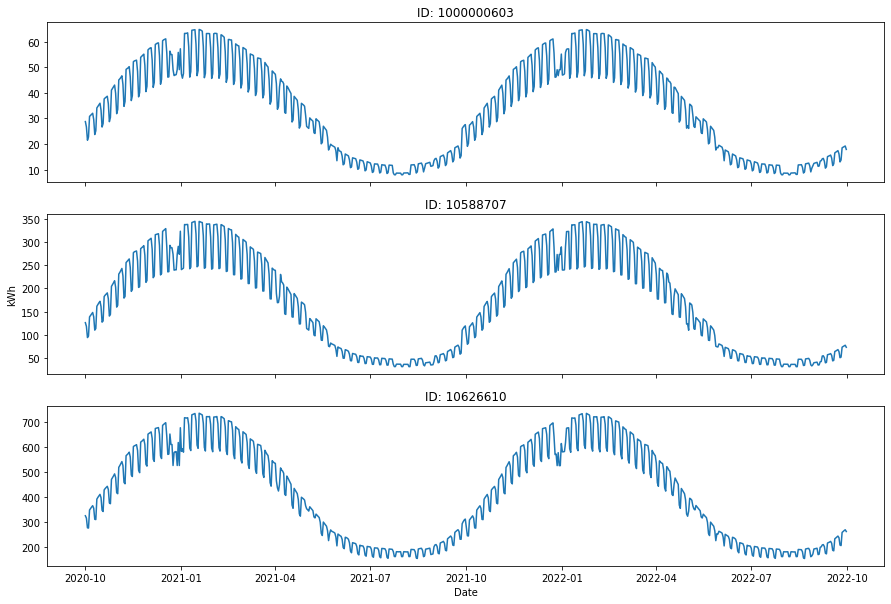

In [4]:
# create the figure space
fig = plt.figure()
fig.set_size_inches(15,10)

#assign three subplots to the figure
ax0 = fig.add_subplot(311)
ax1 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)

# set the titles as the meter ID
ax0.set_title("ID: " + str(meterData["Meter ID"][0]))
ax1.set_title("ID: " + str(meterData["Meter ID"][1]))
ax2.set_title("ID: " + str(meterData["Meter ID"][2]))

# remove the x ticks on the first two plots
ax0.set_xticklabels([])
ax1.set_xticklabels([])

# in each subplot, plot the power usage over time.
ax0.plot(forcastData["Date"].loc[forcastData["Meter ID"] == meterData["Meter ID"][0]],\
        forcastData["kWh"].loc[forcastData["Meter ID"] == meterData["Meter ID"][0]])
ax1.plot(forcastData["Date"].loc[forcastData["Meter ID"] == meterData["Meter ID"][1]],\
        forcastData["kWh"].loc[forcastData["Meter ID"] == meterData["Meter ID"][1]])
ax2.plot(forcastData["Date"].loc[forcastData["Meter ID"] == meterData["Meter ID"][2]],\
        forcastData["kWh"].loc[forcastData["Meter ID"] == meterData["Meter ID"][2]])

ax1.set_ylabel("kWh")
ax2.set_xlabel("Date")


The forcasts follow a sinusoidal relationship.

For the purpose of this exercise I model this data using a cosine centered on Jan 1st with a noise dimension added. An improvement would be to define a function and fit data values to locate key features, e.g peak center, daily use fluctuation. Looking at the signal, a Fourier analysis could help distinguish the several frequencies which appear to make up the signal.



<center> <huge> Mock consumption data example</huge> </center>

![title](figures/mock_consumption.png)


An additional improvement would be to include a time variation on the noise, as the noise can be seen to maximise around Jan in the forcasted data.


In [8]:


def mockCons(mList, start, end, ranSeed = None):
    """
    DESCRIPTION:
        Creates a dataframe of the mock consumption for a list of meters.
        Returns two dataframes in the format
        
        df1:
            
           Date | Meter ID | kWh 
           ------------------------
                |          |     
                |          |     
           ------------------------
           
        df2
            ID | total Consumption (kWh) 
            -------------------------------
               |                        
               |                        
            -------------------------------
            
            
    INPUT:
        mList: A list of meter ID numbers
        start: the start time in format "YYYY-MM-DD"
        end: the end time in format "YYYY-MM-DD"
        
    OUTPUT:
        df1: Dataframe containing daily usage model
        df2: Dataframe containing total consumption value for given period

    """    
    # Create a series of dates
    dates = pd.date_range(start, end)
    
    # Create the two master dataframes to store the results
    df1 = pd.DataFrame(columns = ("Date","Meter ID","kWh"))
    df2 = pd.DataFrame(columns = ("Meter ID","Total Power Consumption (kWh)"))
    
    # We create a model of the daily energy Use for each meter
    # calculate the days off jan 1st (approx reference of peak) to use in
    # cosine estimate. daysOffJan is used to center this cosine wave.
    daysOffJan = abs((pd.Timestamp(str(dates[0].year) + "-01-01") - dates)).days
    
    
    for i in range(len(mList["Meter ID"])):
        
        # create some random noise to represent daily fluctuations
        np.random.seed(ranSeed)
        # it is likely that the noise vaires over hours rather than days (day/night cycle), so we 
        # include a factor of 24 to account for this in the noise.
        noise = 10*np.random.rand(1)*np.sin(np.pi*np.random.randint(50,150,1)*(daysOffJan*24)/365)
        
        # Add the noise to a cosine model peaking on Jan 1st to represent the daily
        # use.
        # The first factor here puts the estimated energy use in a reasonable 
        # regime
        np.random.seed(ranSeed)
        dailyUse = np.random.randint(20,400,1)*np.cos(np.pi*2*daysOffJan/365)+noise
        
        # this just increases the magnitude so our model does not have negative 
        # Daily usage. (no solar panels here!)
        dailyUse += max(abs(dailyUse))*1.1 
        
        # Append the results to the master dataframe.
        df1Temp = pd.DataFrame({"Date":dates,"Meter ID":mList["Meter ID"][i],"kWh":dailyUse})
        df1 = df1.append(df1Temp)
        
        # Again, the total power consumption is just the sum of the daily use
        tpc = df1Temp["kWh"].sum()
        
        # Append the result to the second master dataframe
        df2Temp = pd.DataFrame({"Meter ID":[mList["Meter ID"][i]],"Total Power Consumption (kWh)":[tpc]})
        df2 = df2.append(df2Temp)
        
    
    return df1, df2

# test case
mList = meterList(2)
df1, df2 = mockCons(mList, "2020-01-01","2021-01-01")
print(df1.head(), "\n ... \n", df1.tail())
print(df2)

        Date    Meter ID         kWh
0 2020-01-01  9090942647  280.128318
1 2020-01-02  9090942647  288.127320
2 2020-01-03  9090942647  274.444845
3 2020-01-04  9090942647  275.859187
4 2020-01-05  9090942647  288.294770 
 ... 
           Date    Meter ID         kWh
362 2020-12-28  8793564194  151.606189
363 2020-12-29  8793564194  157.050336
364 2020-12-30  8793564194  153.744161
365 2020-12-31  8793564194  154.884630
366 2021-01-01  8793564194  156.004059
     Meter ID  Total Power Consumption (kWh)
0  9090942647                   55730.091613
0  8793564194                   30928.778490


# Task 4

#### Write a function that takes as an input a meter list and a consumption table and returns the Transportation cost table. Benchmark this function using meter lists of different sizes. Try longer periods as well? How does the function scale? 

I interpreted this task as being similar to the first, with the exception of a variable input. Using the preexisting code from the fisrt task I speed up the writing process.


In [6]:

def transportCost(mList,cTable):
    """
        DESCRIPTION:
            Produces a DataFrame of the Transportation Cost for a given 
            DataFrame of meters and their respective consumption data.
        INPUT:
            mList: The DataFrame containg information about the meters. This
            should be in the from:
                
            Meter ID  |  Exit Zone  |  Annual Quantity (kWh)
            ------------------------------------------------
                      |             |
                      |             |
            ------------------------------------------------
        
            cTable: The DataFrame containing information about the Daily power
            use for a specific time range. This should be in the form:
            
            Date | Meter ID | kWh 
           ------------------------
                 |          |      
                 |          |     
           ------------------------
            
        OUTPUT:
            finalResults: A DataFrame providing the Transportation cost for the
            given meters with given daily consumption rates. This is in the 
            form:
                
            Meter ID | Total Energy Consumption (kWh) | Total Cost (£) 
           -------------------------------------------------------------
                     |                                |                
                     |                                |                
           -------------------------------------------------------------
            

    """
    
    # Again, regarding the reference tables, these could be preallocated by 
    # placing everything within a Class with a setter function. Importing the 
    # data within the function would be an inefficient use of computing power.
    
    # As this function is largely based off Task 1. I have ommited duplicate
    # comments, only including them where there is a change.
    
    # Some noteworthy changes between this and Task 1 however are:
    # 1. We no longer predefine the size of the DataFrame. It is now input driven.
    # 2. We no longer take a date input, this is derived from the input consumption
    # table
    # 3. All instances of the forcastData DataFrame are replaced with cTable, out
    # mock consumption data.
    
    
    transCost = pd.DataFrame(columns = ("Meter ID","Total Estimated Consumption (kWh)",\
                                "Total Cost (£)"))
    for i in range(len(mList["Meter ID"])):
        
        meter = mList.iloc[i] 
        
        critTrueIndex = ratesData.loc[(ratesData["Exit Zone"] == meter["Exit Zone"]) &\
                          (meter["Annual Quantity (kWh)"] > ratesData["Annual Quantity (Min)"])\
                              & (meter["Annual Quantity (kWh)"] < ratesData["Annual Quantity (Max)"]) &\
                          (ratesData["Date"] >= pd.Timestamp("2020-10-1")) & \
                              (ratesData["Date"] <= pd.Timestamp("2022-10-01"))].index.values
        
        meterCalc = pd.DataFrame(columns = ("Date","Rate","Daily use","Cost/day"))
        
        # One difference is that instead of assigning a date range here, we draw it
        # from the input.
        meterCalc["Date"] = pd.date_range(min(cTable["Date"]),max(cTable["Date"]))
        
        for j in range(len(critTrueIndex)-1):
            meterCalc["Rate"].loc[((meterCalc["Date"] >= ratesData["Date"][critTrueIndex[j]]) & \
                                   (meterCalc["Date"] < ratesData["Date"][critTrueIndex[j+1]])).values] \
                                    = ratesData["Rate (p/kWh)"]
        
        
        # We are no longer using the provided data stored in forcastData, 
        # instead we use an input, (which could be the mock consumption model 
        # or the forcast data provided)
        meterCalc["Daily use"] = cTable["kWh"].loc[(cTable["Meter ID"] == meter["Meter ID"])].values
        
        meterCalc["Cost/day"] = meterCalc["Daily use"] * meterCalc["Rate"]
        

        tec = meterCalc["Daily use"].sum()
        tc = meterCalc["Cost/day"].sum() * 0.01
        
        # As we have not preallocated a DataFrame we now use an append function.
        transCost = transCost.append(pd.DataFrame({"Meter ID":[meter["Meter ID"]], \
                                        "Total Estimated Consumption (kWh)":[tec],\
                                         "Total Cost (£)":[tc]})).reset_index(drop = True)
    
    return transCost

# test case

mList = meterList(2)
cTable, df2 = mockCons(mList, "2020-01-01","2021-01-01")
transCost = transportCost(mList,cTable)

print(transCost)

     Meter ID  Total Estimated Consumption (kWh)  Total Cost (£)
0  8059242526                       92896.316739       52.990486
1  7334662362                       95989.884514       55.173347


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Servicability testing and Benchmarking

This is definitely an area I need to improve on. I often run tests within my code however I am unfamiliar with those used in industry. I hope my analysis is acceptable, and I would welcome any feedback on how to improve this. 

Note: These tests took some time to run, so I have included the resultant plot and a discussion of the resuts at the end of each test.

In [7]:
# Servicability Test 1. Comparison of Task 1. output with transportCost() 
# output given the same input parameters. Results should be equal.
    
task1Out = finalResults
task4Out = transportCost(meterData, forcastData)

print("Comparson of Task 1 output with Task 4 function output")
print("Task 1: \n",task1Out)
print("Task 4: \n",task4Out)
print("Boolean comparison of output values: \n", task1Out == task4Out)


Comparson of Task 1 output with Task 4 function output
Task 1: 
      Meter ID  Total Estimated Consumption (kWh)  Total Cost (£)
0  1000000603                       24674.000000       27.924138
1    10588707                      122449.999999      138.568403
2    10626610                      303558.000002      342.926394
Task 4: 
      Meter ID  Total Estimated Consumption (kWh)  Total Cost (£)
0  1000000603                       24674.000000       27.924138
1    10588707                      122449.999999      138.568403
2    10626610                      303558.000002      342.926394
Boolean comparison of output values: 
    Meter ID  Total Estimated Consumption (kWh)  Total Cost (£)
0      True                               True            True
1      True                               True            True
2      True                               True            True


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Test 1. 
Here I compare the outputs of the function with the output generated from Task 1 given the same inputs. This can be run quickly. The result shows the same output which suggests the function and task 1 script are accurate. (Though this should not discount the possibility they could both be wrong!)

In [37]:
# Servicability Test 2: constant meterList size, varying time period

# It is important to set a random seed for these tests. This ensures our random
# values are constant throughout our test for reproducability. I have incorporated
# this into the functions through the ranSeed variable, default is None.


# I test the time to run based on the length of the input.
start = "2020-01-01"
# we vary the end date by 1 month increments:
end = pd.date_range(start = "2021-01-01",end = "2024-01-01", freq = "1M")

# create three meter lists
mList = meterList(3, ranSeed = 0)

# In order to get a better understanding of the trend, I repeat the process
# 100 time
# I create a master array to hold all run times
runTimeMaster1 = []
for i in range(100):
    # I create a list to store the running time of an individual run:
    runTime1 = []
    for endtime in end:
        t0 = time.time() # records the time
        cTable = mockCons(mList, start, endtime, ranSeed = 0)
        transCost = transportCost(mList, cTable[0])
        runTime1.append(time.time()-t0) # append the time to run the code
    # I append this runTime to the master list:
    runTimeMaster1.append(runTime1)

# I set runTimeMaster to be a numpy array so I can evaluate it easier.
runTimeMaster1 = np.array(runTimeMaster1)

# Finally I plot the result of the average

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(end, np.mean(runTimeMaster1,0))
ax.set_xlabel("end date (YYYY-MM)")
ax.set_ylabel("run time (s)")


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

## Test 2

We see how varying the length of the desired period changes the runtime of the function. We keep the number of meters used in the list constant. We set a random seed to keep the consumption data and meter ID data the same, as we are only gauging how the run time varies. We repeat this process 100 times, taking the average of the result which is show in the figure below.

<center> Test 2 Result </center>

![title](figures/runTime_v_endDate.png)


As is expected, increasing the length of the time period increases the run time of the function. The trend appears to be linear. However, there is a drop in processing time around 2022-09. Initially I thought this might be an error due to the forcastData list having a cutoff at ~ 2022-09, though this data source does not enter the function. This might be due to a change in the Rates data, which has a rate switch at ~ 2022-10. Overall the runtime variation is small for this variable.



In [ ]:
# Servicability Test 3: vary meterList size, constant period

# This test is similar to test 1, so I largely duplicate the code.


# I test the time to run based on the length of the input.
start = "2020-01-01"
# This time we keep the end date constant
end = "2021-01-01"


# An array storing the size of the meter DataFrames we will create 
mListSize = range(5,55,5)

# In order to get a better understanding of the trend, I repeat the process
# 100 times
# I create a master array to hold all run times
runTimeMaster2 = []
for i in range(100):
    # I create a list to store the running time of an individual run:
    runTime2 = []
    for size in mListSize:
        mList = meterList(size, ranSeed = 0)
        t0 = time.time() # records the time
        cTable = mockCons(mList, start, end, ranSeed = 0)
        transCost = transportCost(mList, cTable[0])
        runTime2.append(time.time()-t0) # append the time to run the code
    # I append this runTime to the master list:
    runTimeMaster2.append(runTime2)
    
runTimeMaster2 = np.array(runTimeMaster2)

# Again plotting the result.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mListSize, np.mean(runTimeMaster2,0))
ax.set_ylabel("run time(s)")
ax.set_xlabel("number of meters")


## Test 3

We see how varying the number of meters in the list changes the runtime of the function. We keep the time period constant. Again we set a random seed to keep the consumption data and meter ID data the same. Also again, we repeat the process 100 times, taking the average of the result which is show in the figure below.



<center> Test 3 Result </center>

![title](figures/runTime_v_numMeters.png)

This result shows more of an exponential increase. Increasing the number of meters in a list significantly increases the runtime of the function. More so than the length of the time period. I believe this is due to the extra computational demand required when cross referencing Exit Zones and Annual Quanties with the lookup table. Improving this process would likely speed up the function.

As a sanity check, around the lower end of the meter numbers (5), the runtime is comparible to that of the previous test. A further, more accurate check would be to compare the values. However I believe they will be similar (within the realms of numerical error).




In [ ]:
# --------------------------------------
# Servicability Test 4: 2D analysis. Vary meter list size, vary period.


# Using the time periods from Task 2 and the mListSize from Test 3 I create
# a 2D matrix to detail the run time variation

mListSize = range(5,55,5)
start = "2020-01-01"
end = pd.date_range(start = "2021-01-01",end = "2024-01-01", freq = "1M")

runTimeMaster3 = []
for size in mListSize:
    mList = meterList(size, ranSeed = 0)
    runTime3 = []
    for endtime in end:
        t0 = time.time()
        cTable = mockCons(mList, start, endtime, ranSeed = 0)
        transCost = transportCost(mList, cTable[0])
        runTime3.append(time.time()-t0)
    runTimeMaster3.append(runTime3)
runTimeMaster3 = np.array(runTimeMaster3)
    

fig = plt.figure()
ax = fig.add_subplot(111)
mesh = ax.pcolormesh(end,mListSize,runTimeMaster3)
ax.set_ylabel("number of meters")
ax.set_xlabel("end date (YYYY-MM)")
cbar = plt.colorbar(mesh)
cbar.set_label("run time (s)")

## Test 4

Using a single run we can see how varying each variable changes the runtime. Given more processors I would run more results and average the results again. The results are shown in a colour plot. Brighter yellow indicates long run times, while darker blue indicates shorter runtimes.

<center> Test 4 Result </center>

![title](figures/2d_higher_res.png)

Taking the gradient in either the x or y direction will indicate which variable influences the runtime the greatest.


# Task 5.

#### What are your observations after benchmarking? Are there any steps in the cost calculation that can be improved? How would you go about improving the performance of such a calculation?


We see that by both increasing the time period length and the number of meters in the input increases the runtime of the function. The tests run here indicate that the number of meters in the input is the significant factor in determining the runtime. The period length seems to increase the runtime linearly, while the number of meters seems to increase the runtime exponentially. 

Improvements that could be made include:

1. Replacing the criteria search with a groupby function I am not overly familiar with this function, so would work to understand and impllement it. This would work quicker as it removes the need for the loop, thereby vectorising the section.

        for j in range(len(critTrueIndex)-1):  
            meterCalc["Rate"].loc[((meterCalc["Date"] >= ratesData["Date"][critTrueIndex[j]]) & \
                                   (meterCalc["Date"] < ratesData["Date"][critTrueIndex[j+1]])).values] \
                                                              = ratesData["Rate (p/kWh)"] 
        
                          
2. The cross referencing Exit Zones and Annual Quantities with a lookup table. It might be possible to auto assign the values when constructing the mock dataset. This would remove the need for the boolean lookup which agian would remove a step and shorten the script.

        critTrueIndex = ratesData.loc[(ratesData["Exit Zone"] == meter["Exit Zone"]) &\
                      (meter["Annual Quantity (kWh)"] > ratesData["Annual Quantity (Min)"])\
                          & (meter["Annual Quantity (kWh)"] < ratesData["Annual Quantity (Max)"]) &\
                      (ratesData["Date"] >= pd.Timestamp("2020-10-1")) & \
                          (ratesData["Date"] <= pd.Timestamp("2022-10-01"))].index.values      

3. I'm not too sure how this works with pandas, but for numpy it is often more memory efficient to preallocate an array then insert results into the preallocated array. Where I am appending values to an empty dataframe in several functions, this could be sped up by preallocating a DataFrame. 


4. Another loop which might be removed is when I loop through each meter ID. Potentially a groupby function could be used to remove this loop. I believe this would greatly increase the run time and mitigate the exponential dependence on the number of meters. Again, I need to familiarise myself with the groupby function to ensure I implement it correctly.

        for i in range(len(mList["Meter ID"])):
         ...
         
5. Not a performance boost, but the model consumption data could be modeled more realistically by using a Fourier decomposition to obtain information about the underlying frequencies, i.e consumption(t) = gerneral_use(t) + noise_amplitude(t), whereas the model I have now is just consumption(t) = general_use(t) + noise_amplitude. This would result in more accurate price calculations.
         
Further note: 

After saving all results from tests 2 - 4 I would implement these changes, rerun the tests with the updated functions and compare the results with the results from the initial test to quantify any changes.